<h3 style="text-align: center;"><b>Autoencoders</b></h3>



# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (1 балл)


In [ ]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt

import os
import pandas as pd
import skimage.io
from skimage.transform import resize

import torch
from torchvision import transforms
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE


from torch.utils.data import Dataset, Subset, DataLoader
import torchvision.transforms as tfs
from typing import Tuple, List, Dict
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from IPython.display import clear_output
from torchsummary import summary
from time import time


%matplotlib inline

In [ ]:
# Set a random seed for reproducibility
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

The choice of image_size and batch_size in GANs (Generative Adversarial Networks) depends on various factors, and there's no one-size-fits-all answer. However, certain considerations can guide your decision:

Image Size:

Larger Images: Larger image sizes, such as 128x128, can capture more details and result in higher-resolution generated images. This can be beneficial if your target application requires high-quality, detailed images.
Smaller Images: Smaller image sizes, like 64x64, might be preferred if you have constraints on memory or computational resources. Smaller images can also lead to faster training times.
Batch Size:

Larger Batch Sizes: Using larger batch sizes can lead to more stable and faster convergence during training. GANs often benefit from larger batch sizes because they involve a competitive process between the generator and discriminator.
Smaller Batch Sizes: Smaller batch sizes might be necessary if you have limited GPU memory. However, very small batch sizes can introduce noise and instability into the training process.
Here are some general reasons why an image size of 128 and a batch size of 12 might be considered:

Balance Between Detail and Resources: An image size of 128 strikes a balance between capturing sufficient detail and maintaining reasonable computational efficiency. It's larger than standard sizes like 64x64 but not as computationally demanding as very high-resolution images.

Moderate Batch Size: A batch size of 12 is not extremely small, allowing for a balance between stability during training and efficient use of computational resources. Larger batch sizes can sometimes lead to better utilization of parallel processing capabilities in modern GPUs.

Keep in mind that these choices often involve trade-offs, and the optimal configuration can depend on your specific dataset, model architecture, and available resources. It's recommended to experiment with different configurations and monitor the training progress to find the settings that work best for your particular GAN and dataset.







In [ ]:
IMAGE_SIZE = 64
BATCH_SIZE = 32
# TBD
# IMAGE_SIZE = 128
# BATCH_SIZE = 4


In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind

data, attrs = fetch_dataset(dimx=IMAGE_SIZE,dimy=IMAGE_SIZE)

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


In [ ]:
len(data)

13143

In [ ]:
attrs.head()

Male     Asian     White     Black      Baby     Child     Youth  \
0  1.568346 -1.889043  1.737203 -0.929729 -1.471799  -0.19558 -0.835609   
1  0.169851 -0.982408  0.422709 -1.282184  -1.36006 -0.867002 -0.452293   
2  0.997749 -1.364195 -0.157377 -0.756447 -1.891825 -0.871526 -0.862893   
3  1.122719 -1.997799  1.916144 -2.514214 -2.580071 -1.404239  0.057551   
4  1.078214 -2.008098  1.676211 -2.278056 -2.651845 -1.348408  0.649089   

  Middle Aged    Senior Black Hair  ... Pale Skin 5 o' Clock Shadow  \
0   -0.351468 -1.012533  -0.719593  ...  0.361738          1.166118   
1   -0.197521 -0.956073  -0.802107  ... -0.832036          -0.39768   
2    0.031445 -1.341523  -0.090037  ...  1.549743          1.884745   
3    0.000196 -1.273512  -1.431462  ...  0.567822         -0.176089   
4    0.017656 -1.889111  -1.857213  ... -1.461474         -0.955283   

  Strong Nose-Mouth Lines Wearing Lipstick Flushed Face High Cheekbones  \
0               -1.164916         -1.13999    -2.371746       -1.299932   
1                 0.87416        -0.945431    -0.268649       -0.006244   
2               -0.999765        -1.359858    -1.912108       -1.095634   
3                1.108125        -1.600944    -3.264613        0.813418   
4                0.119113        -1.128176    -3.161048         0.08268   

  Brown Eyes Wearing Earrings Wearing Necktie Wearing Necklace  
0  -0.414682        -1.144902        0.694007        -0.826609  
1  -0.030406        -0.480128         0.66676        -0.496559  
2   0.915126        -0.572332        0.144262        -0.841231  
3   0.308631        -0.848693        0.475941        -0.447025  
4  -0.439614        -0.359859       -0.760774        -0.410152  

[5 rows x 73 columns]


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [ ]:
photos_train, photos_valid, attrs_train, attrs_valid = train_test_split(
    data, attrs, train_size=0.8, shuffle=False
)

dataloader = {
    'train': DataLoader(photos_train, batch_size=BATCH_SIZE, shuffle=True),
    'valid': DataLoader(photos_valid, batch_size=BATCH_SIZE),
}

In [ ]:
photos_train[0].shape
len(photos_train)

10514

In [ ]:
def show_faces(faces: np.ndarray, size: Tuple[int, int] = None):
    if size is None:
        rows = (len(faces) + 7) // 8
        cols = len(faces) if len(faces) < 8 else 8
    else:
        rows, cols = size
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    for ax, img in zip(axes.flatten(), faces):
        ax.axis('off')
        torch.clip(img, 0, 1)
        ax.imshow(img.numpy())

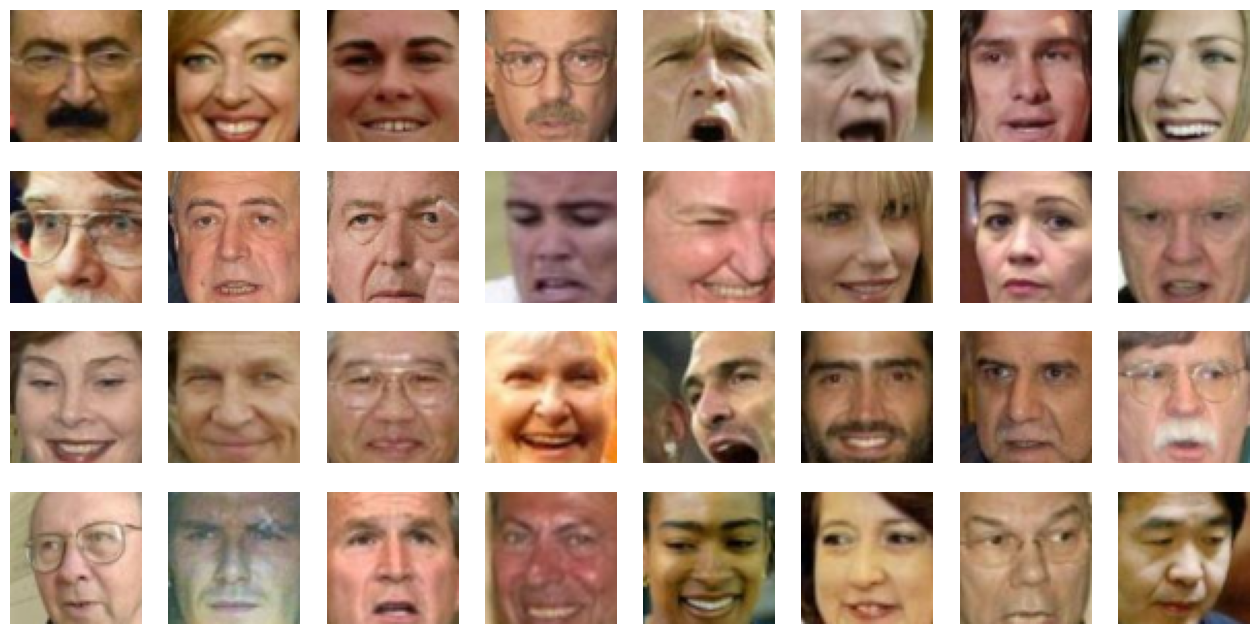

In [ ]:
batch = next(iter(dataloader['train']))
show_faces(batch)

## 1.2. Архитектура модели (2 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [ ]:
# Set latent size
LATENT_SIZE = 64

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
DROPOUT_RATE = 0.5

class AutoencoderConv(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=2, padding=1),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=2, padding=1),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=2, padding=1),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Dropout(DROPOUT_RATE),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(3, 3), stride=2, padding=1),

            nn.Conv2d(in_channels=128, out_channels=16, kernel_size=(3, 3), padding=1),
            nn.ReLU(),

            nn.Flatten(),
        )
        # 16 x 4 x 4
        self.decoder = nn.Sequential(
            nn.Unflatten(-1, (16, 4, 4)),

            nn.Conv2d(in_channels=16, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),

            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),

            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),

            nn.Conv2d(in_channels=32, out_channels=3, kernel_size=(3, 3), padding=1),
            nn.Sigmoid(),
        )

    def forward(self, sample):
        latent = self.encoder(sample)
        reconstructed = self.decoder(latent)
        return reconstructed, latent

    def latent(self, sample):
        latent = self.encoder(sample)
        return latent

    def sample(self, z: torch.Tensor) -> torch.Tensor:
        generated = self.decoder(z)
        return generated

In [ ]:
class AutoencoderFC(torch.nn.Module):
    def __init__(self, latent_size: int):
        super().__init__()
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=(3 * IMAGE_SIZE * IMAGE_SIZE), out_features=256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(in_features=256, out_features=512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=latent_size),
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_size, out_features=512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(in_features=512, out_features=256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=(3 * IMAGE_SIZE * IMAGE_SIZE)),
        )


    def forward(self, sample):
        sample = self.flatten(sample).float()
        latent_code = self.encoder(sample)
        reconstructed = self.decoder(latent_code)
        return reconstructed, latent_code


    def get_latent(self, sample):
        sample = self.flatten(sample).float()
        latent = self.encoder(sample)
        return latent

    def get_sample(self, z: torch.Tensor) -> torch.Tensor:
        generated = self.decoder(z)
        return generated


In [ ]:
# Function to train the autoencoder
def train_ae(
    model: nn.Module,
    dataloader: Dict[str, DataLoader],
    criterion: nn.Module,
    optimizer: nn.Module,
    epochs: int = 20,
    visualize = True
):

    losses = {'train': [], 'valid': []}
    last_original_batch, last_reproduction_batch = None, None


    for epoch in range(epochs):

        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))
        for phase in ['train', 'valid']:
            loss_accum = []
            model.train(mode=(phase == 'train'))

            for inputs in dataloader[phase]:
                inputs = inputs.to(device)

                if phase == 'train':
                    # set parameter gradients to zero
                    optimizer.zero_grad()
                    outp, _ = model(inputs)

                    outp = outp.view(-1, IMAGE_SIZE, IMAGE_SIZE, 3)

                    loss = criterion(outp, inputs.float())
                    loss.backward()
                    optimizer.step()
                else:
                    with torch.no_grad():
                        outp, _ = model(inputs)
                        outp = outp.view(-1, IMAGE_SIZE, IMAGE_SIZE, 3)
                        loss = criterion(outp, inputs.float())
                    if visualize:
                      last_original_batch, last_reproduction_batch = inputs, outp

                loss_accum.append(loss.item())
            phase_loss = np.mean(loss_accum)
            losses[phase].append(phase_loss)

            if phase == 'valid' and visualize:
                with torch.no_grad():
                  original = last_original_batch.cpu().detach()
                  reproduction = last_reproduction_batch.cpu().detach()

                # plt.figure(figsize=(16, 16))
                plt.suptitle('%d / %d - train loss: %f , val loss: %f ' % (epoch+1, epochs, losses['train'][-1], losses['valid'][-1]))
                clear_output(wait=True)
                cols = original.size(0)
                for j in range(cols):
                    plt.subplot(2, cols, j + 1)
                    plt.imshow(original[j].numpy())
                    plt.title('O')
                    plt.axis('off')
                    plt.subplot(2, cols, j + 1 + cols)
                    plt.imshow(reproduction[j].numpy())
                    plt.title('R')
                    plt.axis('off')

                plt.show()
                # progress.set_description('loss: {:.4f}'.format(phase_loss))
        print('%d / %d - train loss: %f , val loss: %f ' % (epoch+1, epochs, losses['train'][-1], losses['valid'][-1]))

        # At the end of a training iteration or epoch, before the next iteration/epoch
        if torch.cuda.is_available():
          with torch.no_grad():
            torch.cuda.empty_cache()
    return losses

In [ ]:
# Initialize model, loss, and optimizer
autoencoder = AutoencoderFC(latent_size=LATENT_SIZE).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.0001)
EPOCH = 40
losses = train_ae(autoencoder, dataloader, criterion, optimizer, epochs=EPOCH, visualize = False)

* Epoch 1/40
1 / 40 - train loss: 0.084040 , val loss: 0.022286 
* Epoch 2/40
2 / 40 - train loss: 0.025915 , val loss: 0.019123 
* Epoch 3/40
3 / 40 - train loss: 0.022272 , val loss: 0.017815 
* Epoch 4/40
4 / 40 - train loss: 0.020502 , val loss: 0.016896 
* Epoch 5/40
5 / 40 - train loss: 0.019307 , val loss: 0.016077 
* Epoch 6/40
6 / 40 - train loss: 0.018383 , val loss: 0.015380 
* Epoch 7/40
7 / 40 - train loss: 0.017477 , val loss: 0.014747 
* Epoch 8/40
8 / 40 - train loss: 0.016889 , val loss: 0.014581 
* Epoch 9/40
9 / 40 - train loss: 0.016306 , val loss: 0.014292 
* Epoch 10/40
10 / 40 - train loss: 0.015792 , val loss: 0.013570 
* Epoch 11/40
11 / 40 - train loss: 0.015442 , val loss: 0.013343 
* Epoch 12/40
12 / 40 - train loss: 0.015012 , val loss: 0.013021 
* Epoch 13/40
13 / 40 - train loss: 0.014758 , val loss: 0.012748 
* Epoch 14/40
14 / 40 - train loss: 0.014482 , val loss: 0.012472 
* Epoch 15/40
15 / 40 - train loss: 0.014233 , val loss: 0.012307 
* Epoch 16/40

In [ ]:
def show_metrics(metrics: Dict[str, List[float]]) -> None:
    plt.figure(figsize=(12, 8))
    plt.plot(metrics['train'], label='train')
    plt.plot(metrics['valid'], label='validation')
    plt.grid()
    plt.legend()
    plt.show()

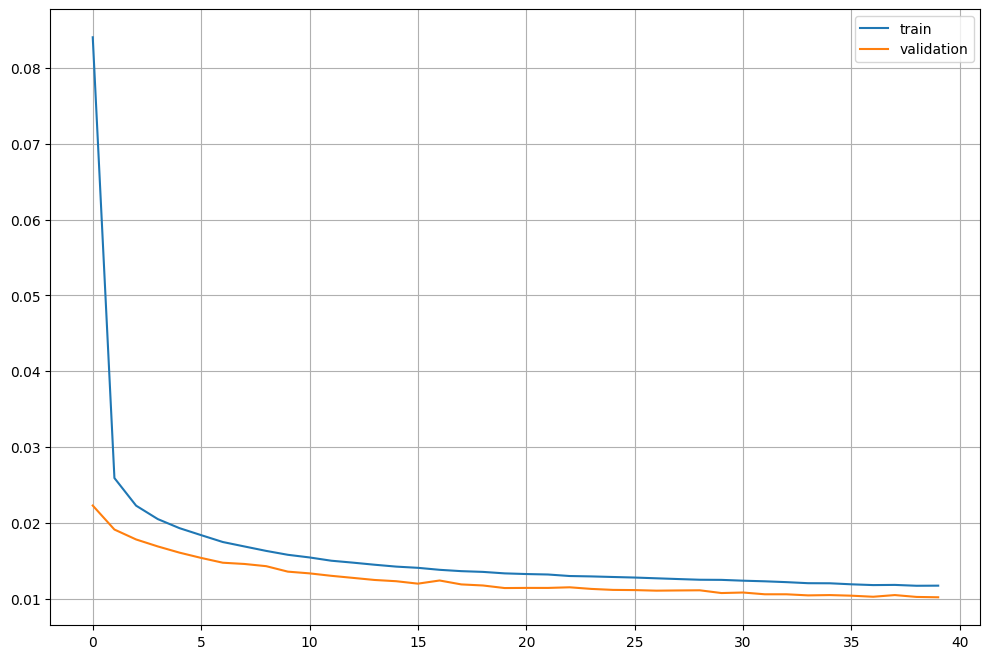

min train loss 0.011707583733899433, min valid loss 0.01018938740872475


In [ ]:
# look at loss function...
show_metrics(losses)
print('min train loss {}, min valid loss {}'.format(
    min(losses['train']), min(losses['valid'])))

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [ ]:
def show_faces(faces: np.ndarray, size: Tuple[int, int] = None):
    if size is None:
        rows = (len(faces) + 7) // 8
        cols = len(faces) if len(faces) < 8 else 8
    else:
        rows, cols = size
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    for ax, img in zip(axes.flatten(), faces):
        ax.axis('off')
        ax.imshow(img.numpy())

In [ ]:
def get_reconstruction(model, batch):
    model.eval()
    with torch.no_grad():
        reconstruction, _ = model(batch.to(device))
    reconstruction = reconstruction.view(-1, IMAGE_SIZE, IMAGE_SIZE, 3)
    reconstruction = reconstruction.cpu().detach()
    return reconstruction

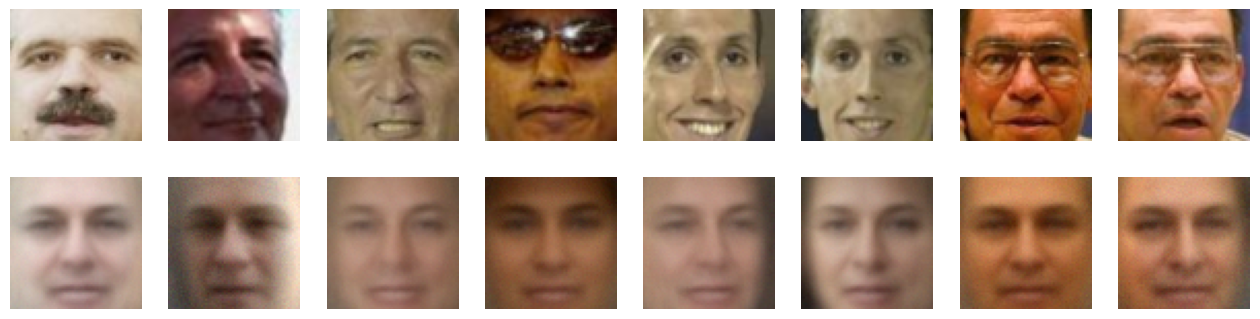

In [ ]:
X_batch = next(iter(dataloader['valid']))
reconstruction = get_reconstruction(autoencoder, X_batch)

pairs = torch.cat((X_batch[:8], reconstruction[:8]))
show_faces(pairs, size=(2, 8))

Not bad, right?

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [ ]:
def get_samples(model, latent):
    model.eval()
    with torch.no_grad():
        sample = model.get_sample(latent.to(device))
    sample = sample.view(-1, IMAGE_SIZE, IMAGE_SIZE, 3)
    sample = sample.cpu().detach()
    return sample

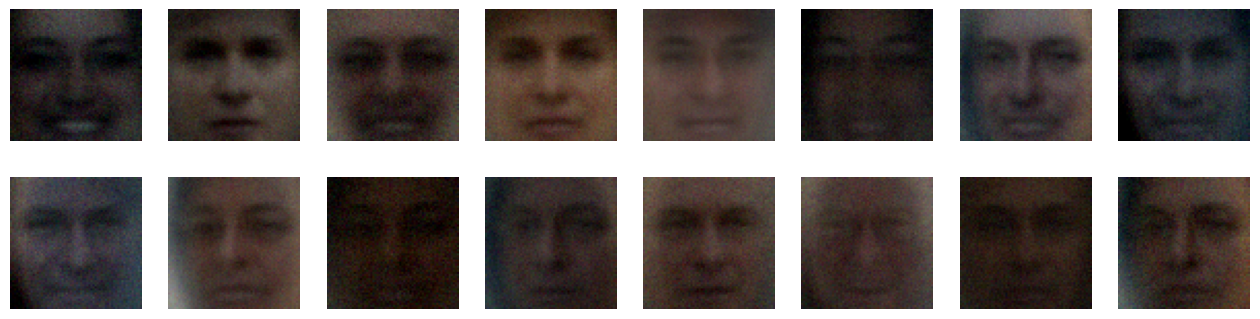

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.random.randn(25, LATENT_SIZE)
z = torch.FloatTensor(z)

samples = get_samples(autoencoder, z)
show_faces(samples, size=(2, 8))

In [ ]:
latents = torch.Tensor()
for inputs in tqdm(dataloader['train']):
    inputs = inputs.to(device)
    with torch.no_grad():
        latent = autoencoder.get_latent(inputs).cpu()

        latents = torch.cat((latents, latent))
print(latents.shape)

lat_mean = latents.mean(dim=0)
lat_std = latents.std(dim=0)
lat_mean.shape, lat_std.shape

  0%|          | 0/329 [00:00<?, ?it/s]

torch.Size([10514, 64])


(torch.Size([64]), torch.Size([64]))

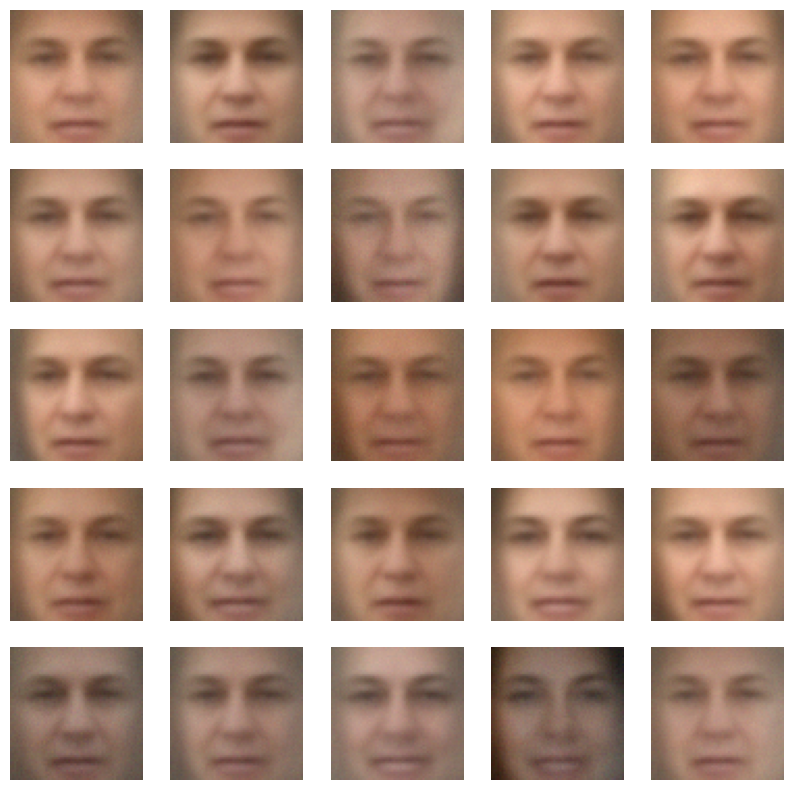

In [ ]:
z = torch.FloatTensor(np.random.randn(25, LATENT_SIZE))
z = z * lat_std/2 + lat_mean
samples = get_samples(autoencoder, z)
show_faces(samples, size=(5, 5))

## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
# Create the index
print(len(attrs_train))
index_ = ['Row_' + str(i) for i in range(len(attrs_train))]

# Set the index
attrs_train.index = index_



10514


In [ ]:
def filter_images_by_smiling(photos_train, attrs_df, smiling_threshold=2, start_index = 0):
    smiling_images = []
    sad_images = []
    index = start_index

    while index < len(attrs_train):
      smiling_value = attrs_df.loc['Row_'+str(index), 'Smiling']

      if smiling_value > smiling_threshold:
          smiling_images.append(photos_train[index])
      elif smiling_value < -smiling_threshold:
          sad_images.append(photos_train[index])

      # Break once you have collected enough images
      if len(smiling_images) >= BATCH_SIZE and len(sad_images) >= BATCH_SIZE:
          break
      index+=1

    return smiling_images[:min(BATCH_SIZE, len(smiling_images))], sad_images[:min(BATCH_SIZE, len(sad_images))]

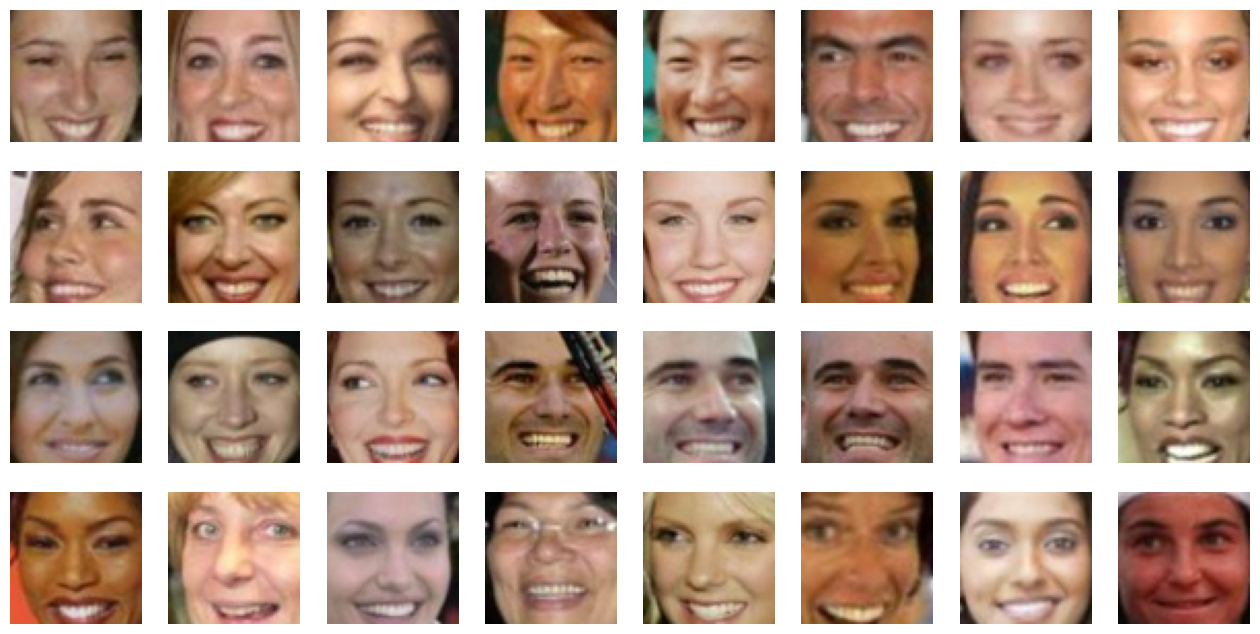

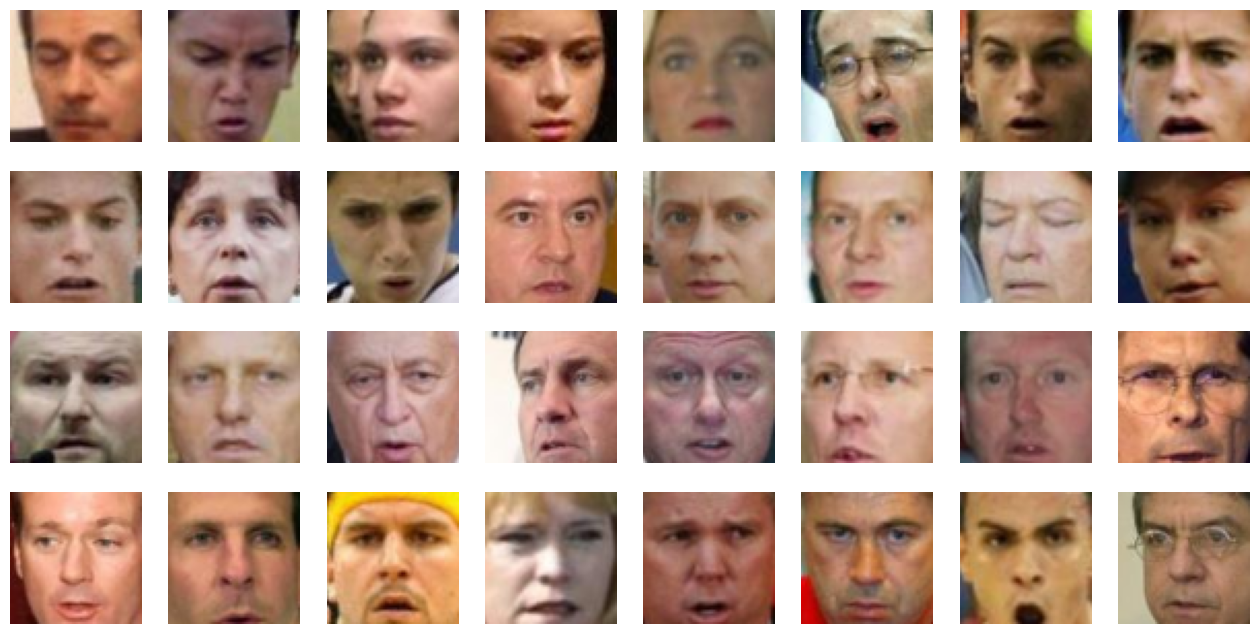

In [ ]:
smiling_images, sad_images = filter_images_by_smiling(photos_train, attrs_train)
smiling_data_loader = DataLoader(smiling_images, batch_size=BATCH_SIZE)
smiling_data_batch = next(iter(smiling_data_loader))
show_faces(smiling_data_batch)

sad_data_loader = DataLoader(sad_images, batch_size=BATCH_SIZE)
sad_data_batch = next(iter(sad_data_loader))
show_faces(sad_data_batch)

In [ ]:
smiling_latent = torch.Tensor()
smiling_data_batch = smiling_data_batch.to(device)
autoencoder.eval()
with torch.no_grad():
    smiling_latent = autoencoder.get_latent(smiling_data_batch).cpu()

sad_latent = torch.Tensor()
sad_data_batch = sad_data_batch.to(device)
with torch.no_grad():
    sad_latent = autoencoder.get_latent(sad_data_batch).cpu()


In [ ]:
smile_vector = smiling_latent.mean(dim=0) - sad_latent.mean(dim=0)

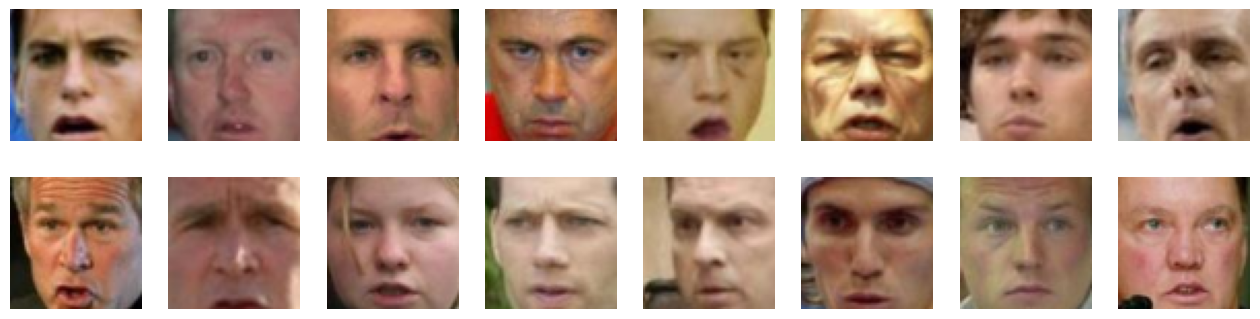

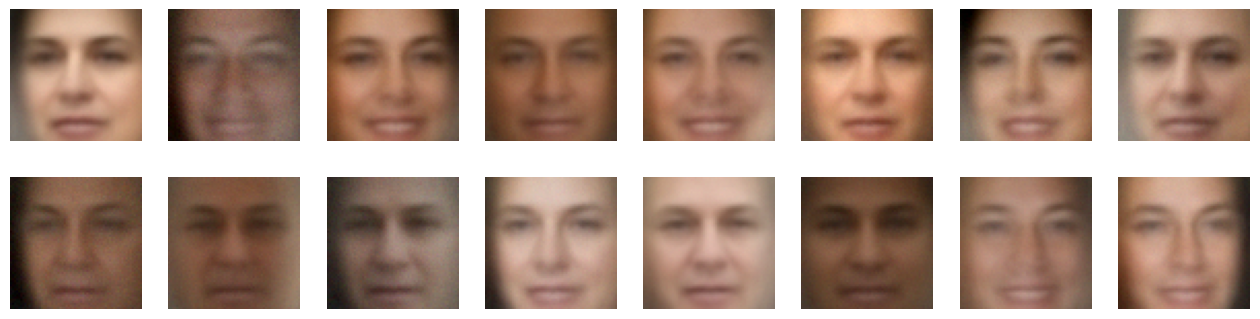

In [ ]:
smiling_images, sad_images = filter_images_by_smiling(photos_train, attrs_train, 2.4)

sad_data_loader = DataLoader(sad_images, batch_size=BATCH_SIZE)
sad_data_batch = next(iter(sad_data_loader))
show_faces(sad_data_batch,size=(2, 8))

sad_data_batch = sad_data_batch.to(device)
autoencoder.eval()
with torch.no_grad():
    sad_latent = autoencoder.get_latent(sad_data_batch).cpu()
    latent_sad_to_smile = (sad_latent + smile_vector).to(device)
    smile_reconstruction_batch = autoencoder.get_sample(latent_sad_to_smile)

smile_reconstruction_batch = smile_reconstruction_batch.view(-1, IMAGE_SIZE, IMAGE_SIZE, 3)
smile_reconstruction_batch = smile_reconstruction_batch.cpu()
show_faces(smile_reconstruction_batch, size=(2, 8))




Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

Autoencoders (AE) and Variational Autoencoders (VAE) are both types of neural network architectures designed for unsupervised learning and feature extraction. While they share the concept of encoding and decoding data, there are key differences between the two models.

1.Objective:

Autoencoder (AE): AEs aim to learn a compressed, fixed-size representation (latent space) of the input data while minimizing reconstruction error. The objective is to encode the input into a compact representation that can be decoded to reconstruct the original input as accurately as possible.
Variational Autoencoder (VAE): VAEs, on the other hand, have a probabilistic interpretation. They not only seek to reconstruct input data but also aim to learn a probabilistic distribution in the latent space. VAEs enforce a structure on the latent space that allows for generating new samples by sampling from this distribution.

2.Latent Space Representation:

AE: The latent space of an AE is typically a fixed and deterministic representation. Each point in the latent space corresponds to a specific encoding of the input data.
VAE: The latent space of a VAE is probabilistic and follows a specific distribution, often a Gaussian distribution. This allows for generating new samples by sampling from the latent space distribution.

3.Regularization:

AE: AEs use traditional regularization techniques, such as dropout or weight regularization, to prevent overfitting and control the capacity of the model.
VAE: VAEs are regularized by design. The introduction of a probabilistic distribution in the latent space encourages smooth and continuous representations, and the model incorporates a term in the loss function that enforces a similarity to a predefined distribution (usually Gaussian).

4.Generative Capability:

AE: AEs are primarily used for encoding and decoding, and they are not inherently generative. Generating new samples from an AE requires additional techniques.
VAE: VAEs are generative models. The probabilistic nature of the latent space allows for generating novel samples by sampling from the learned distribution.
5.Use Cases:

AE: AEs are often used for tasks like denoising, dimensionality reduction, and feature learning.
VAE: VAEs are particularly well-suited for generative tasks, such as image synthesis and data generation.


# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [ ]:
MNIST_BATCH_SIZE = 32

In [ ]:
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=MNIST_BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=MNIST_BATCH_SIZE, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 123463851.60it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 8048348.54it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 34400402.89it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 4058485.04it/s]


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [ ]:
# MNIST Dataset split
images_train, images_valid = train_test_split(
    train_dataset, train_size=0.8, shuffle=False
)

In [ ]:
len(images_train)

48000

In [ ]:
train_loader = {
    'train': DataLoader(images_train, batch_size=MNIST_BATCH_SIZE, shuffle=True),
    'valid': DataLoader(images_valid, batch_size=MNIST_BATCH_SIZE),
}

In [ ]:
def show_digits(images, num_images= 5):
    images = images[:num_images]
    fig, axes = plt.subplots(1, num_images, figsize=(12, 2))

    for i in range(num_images):
      axes[i].imshow(images[i].squeeze().numpy(), cmap='gray')
      axes[i].axis('off')

    plt.show()

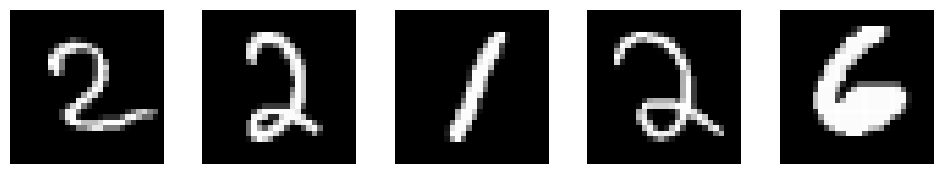

In [ ]:
# Get a batch of images from the training loader
images_batch, _ = next(iter(train_loader['train']))

show_digits(images_batch, num_images=5)


In [ ]:
print(images_batch[0].shape)
CHANNELS = images_batch[0].shape[0]
MNIST_IMAGE_SIZE = images_batch[0].shape[1]

torch.Size([1, 28, 28])


## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!




In the context of the VAE's gaussian_sampler method:

std=exp(0.5⋅logsigma)

Here, the factor of 0.5 is used because the standard deviation is the square root of the variance, and during the transition from the log variance to the standard deviation, we take the square root by multiplying the log variance by 0.5.

In [ ]:
HIDDEN_DIM = 256

class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=(CHANNELS * MNIST_IMAGE_SIZE * MNIST_IMAGE_SIZE), out_features=256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.25),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.25),
            nn.Linear(in_features=128, out_features=(HIDDEN_DIM * 2)),
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=HIDDEN_DIM, out_features=128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.25),
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.25),
            nn.Linear(in_features=256, out_features=(CHANNELS * MNIST_IMAGE_SIZE * MNIST_IMAGE_SIZE)),
            nn.Sigmoid(),
        )

    def encode(self, x):
        x = self.flatten(x).float()
        x = self.encoder(x).view(-1, 2, HIDDEN_DIM)
        mu = x[:, 0, :]
        logsigma = x[:, 1, :]
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            sample = mu + (eps * std)
            return sample
        else:
            return mu

    def decode(self, z):
        reconstruction = self.decoder(z)
        reconstruction = reconstruction.view(-1, CHANNELS, MNIST_IMAGE_SIZE, MNIST_IMAGE_SIZE)
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction

    def get_sample(self, z):
      return self.decode(z)

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:

class KLDivergenceLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, mu: torch.Tensor, logsigma: torch.Tensor):
      epsilon = 1e-10
      return -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp() + epsilon)


class VAELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.kl_divergence = KLDivergenceLoss()
        self.log_likelihood = nn.BCELoss(reduction='sum')

    def forward(self, mu: torch.Tensor,logsigma: torch.Tensor,reconstruction: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
      epsilon = 1e-10
      reconstruction = torch.clamp(reconstruction, min = epsilon, max = 1.0 - epsilon)
      x = torch.clamp(x, min = epsilon, max = 1.0 - epsilon)
      return self.kl_divergence(mu, logsigma) + self.log_likelihood(reconstruction, x)


In [ ]:
if torch.cuda.is_available():
  with torch.no_grad():
    torch.cuda.empty_cache()

И обучим модель:

In [ ]:
def train_vae(
    model: nn.Module,
    dataloader: Dict[str, DataLoader],
    criterion: nn.Module,
    optimizer: nn.Module,
    epochs: int = 25
) -> Dict[str, List[float]]:
    losses = {'train': [], 'valid': []}
    progress = tqdm(range(epochs), desc='Epoch')

    for epoch in progress:
        for phase in ['train', 'valid']:
            loss_accum = []
            model.train(mode=(phase == 'train'))

            for inputs, _ in dataloader[phase]:
                inputs = inputs.to(device)

                if phase == 'train':
                    optimizer.zero_grad()
                    mu, logsigma, reconstruction = model(inputs)
                    loss = criterion(mu, logsigma, reconstruction, inputs.float())
                    loss.backward()
                    optimizer.step()
                else:
                    with torch.no_grad():
                        mu, logsigma, reconstruction = model(inputs)
                        loss = criterion(mu, logsigma, reconstruction, inputs.float())

                loss_accum.append(loss.item())


            phase_loss = np.mean(loss_accum)
            losses[phase].append(phase_loss)
            progress.set_description('loss: {:.4f}'.format(phase_loss))

    return losses


In [ ]:
autoencoder_vae = VAE().to(device)
summary(autoencoder_vae, input_size=(CHANNELS, MNIST_IMAGE_SIZE, MNIST_IMAGE_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
              ReLU-3                  [-1, 256]               0
       BatchNorm1d-4                  [-1, 256]             512
           Dropout-5                  [-1, 256]               0
            Linear-6                  [-1, 128]          32,896
              ReLU-7                  [-1, 128]               0
       BatchNorm1d-8                  [-1, 128]             256
           Dropout-9                  [-1, 128]               0
           Linear-10                  [-1, 512]          66,048
           Linear-11                  [-1, 128]          32,896
             ReLU-12                  [-1, 128]               0
      BatchNorm1d-13                  [-1, 128]             256
          Dropout-14                  [

In [ ]:
criterion = VAELoss()
optimizer = torch.optim.Adam(autoencoder_vae.parameters(), lr=0.0001, weight_decay=1e-5)
EPOCHS = 50
losses = train_vae(autoencoder_vae, train_loader, criterion, optimizer, epochs=EPOCHS)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

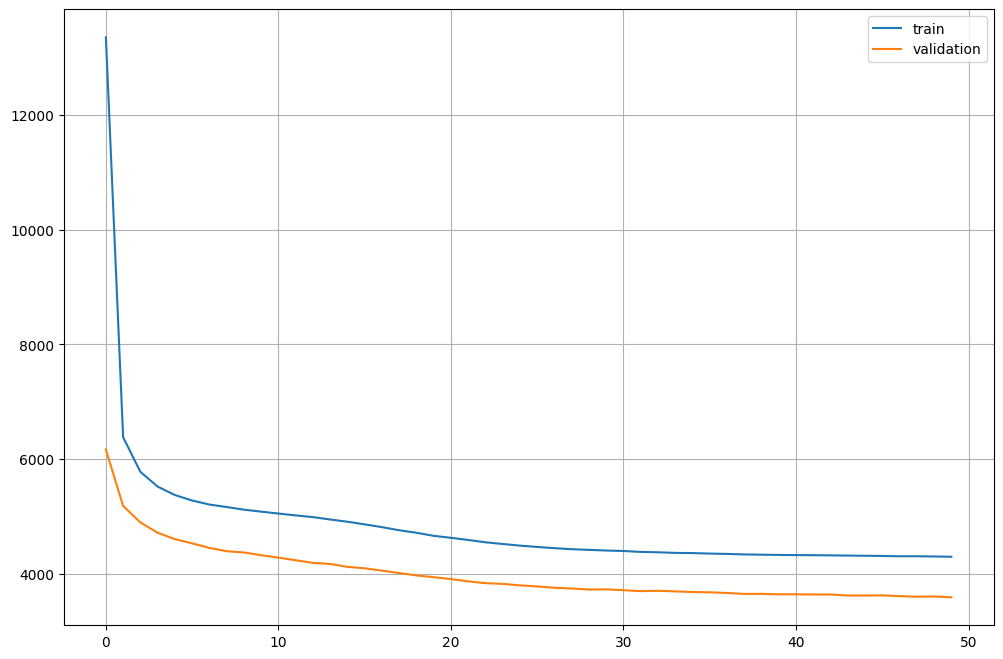

In [ ]:
show_metrics(losses)

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

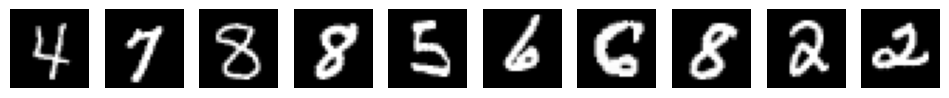

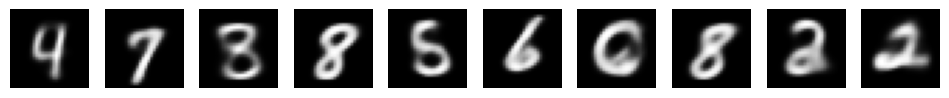

In [ ]:
batch, _ = next(iter(train_loader['valid']))
autoencoder_vae.eval()
with torch.no_grad():
  mu, log_var, reconstruction = autoencoder_vae(batch.to(device))

show_digits(batch, num_images=10)
reconstruction = reconstruction.cpu().detach().view(-1, MNIST_IMAGE_SIZE, MNIST_IMAGE_SIZE, CHANNELS)
show_digits(reconstruction, num_images=10)


Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [ ]:
def get_digits_sample(model, latent):
    model.eval()
    with torch.no_grad():
        sample = model.get_sample(latent.to(device))
    sample = sample.view(-1, MNIST_IMAGE_SIZE, MNIST_IMAGE_SIZE, CHANNELS)
    sample = sample.cpu().detach()
    return sample

torch.Size([10, 256])


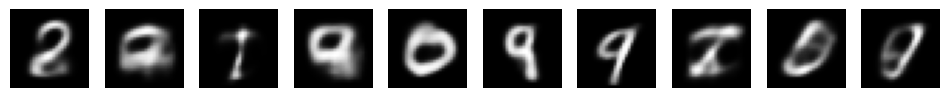

In [ ]:
z = np.array([np.random.normal(0, 1, HIDDEN_DIM) for i in range(10)])
z = torch.FloatTensor(z)
print(z.shape)

reconstruction = get_digits_sample(autoencoder_vae, z)
reconstruction = reconstruction.cpu().detach().view(-1, MNIST_IMAGE_SIZE, MNIST_IMAGE_SIZE, CHANNELS)
show_digits(reconstruction, num_images=10)

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

inspired by https://datareview.info/article/algoritm-t-sne-illyustrirovannyiy-vvodnyiy-kurs/

In [ ]:
def get_latent_vectors(model, dataloader):
  # Step 1
  model.eval()

  latent_vectors = []
  true_labels = []

  with torch.no_grad():
      for batch in dataloader:
          images, labels = batch
          images = images.to(device)
          mu, _ = model.encode(images)
          latent_vectors.append(mu.cpu())
          true_labels.append(labels.float().cpu())

  # Convert lists of tensors to a single tensor
  latent_vectors = torch.cat(latent_vectors, dim=0)
  true_labels = torch.cat(true_labels, dim=0)

  return latent_vectors.cpu(), true_labels


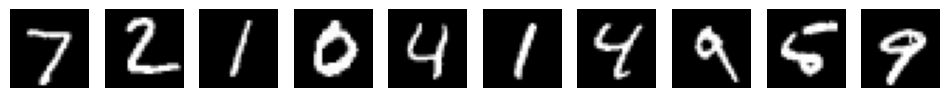

true_labels tensor([7., 2., 1., 0., 4., 1., 4., 9., 5., 9.])


In [ ]:
latent_vectors, true_labels = get_latent_vectors(autoencoder_vae, test_loader)
# Get a batch of images from the training loader
images_batch, _ = next(iter(test_loader))
show_digits(images_batch, num_images=10)

# print("latent vectors",latent_vectors[:10])
print("true_labels", true_labels[:10])

In [ ]:
len(true_labels)

10000

In [ ]:
def plot_tsne(latent_vectors, true_labels):
    # Step 3: Visualize the 2D latent representations
    plt.figure(figsize=(10, 8))

    # Assign different colors to points corresponding to each class
    unique_labels = torch.unique(true_labels)
    colors = plt.cm.rainbow(torch.arange(len(unique_labels)) / len(unique_labels))

    # Scatter plot for each class
    for class_idx, class_label in enumerate(unique_labels):
        indices = (true_labels == class_label).nonzero(as_tuple=True)[0]
        plt.scatter(latent_vectors[indices, 0], latent_vectors[indices, 1], c=colors[class_idx], label=str(int(class_label)))

    plt.title('t-SNE Visualization of Latent Vectors')
    plt.legend()
    plt.show()


<ipython-input-161-8861c6149737>:15: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(latent_vectors[indices, 0], latent_vectors[indices, 1], c=colors[class_idx], label=str(int(class_label)))


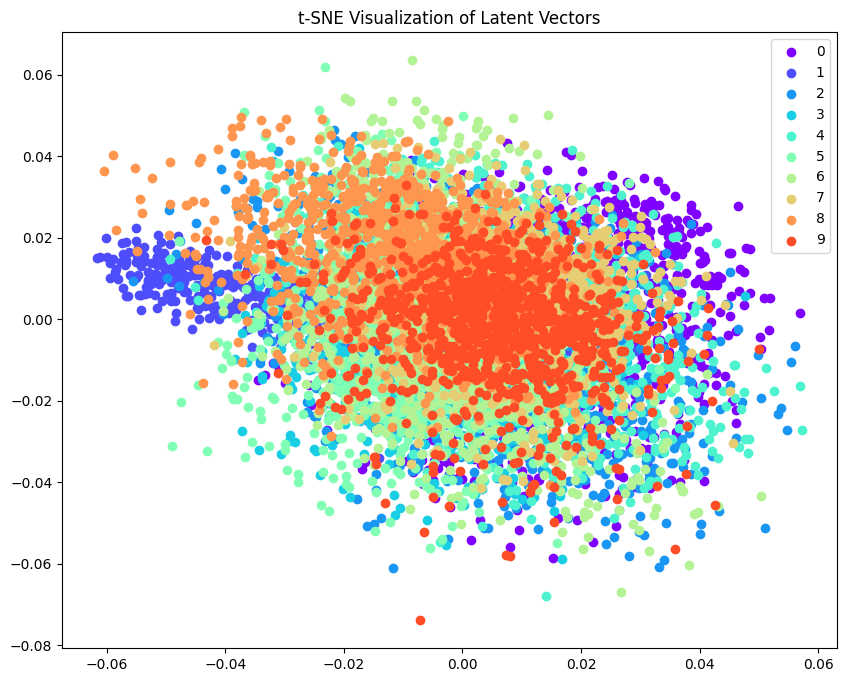

In [ ]:
plot_tsne(latent_vectors[:10000], true_labels[:10000])

Что вы думаете о виде латентного представления?

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

Passing y (class labels) to both the encoder and decoder in a Conditional Variational Autoencoder (CVAE) serves the purpose of enabling the model to generate images conditioned on specific classes. Here's a breakdown of the reasons for passing y to both the encoder and decoder:

Encoding with Labels (y) in the Encoder:

When encoding an input image x using the encoder, the class label information (y) is concatenated with the flattened input (x). This helps the encoder to learn a representation (latent space) that not only captures the inherent features of the input image but also incorporates information about the class to which the image belongs.
The encoder learns to map the input image and its corresponding class label to a meaningful latent space representation (z).
Sampling from Latent Space (z):

The sampled latent vector (z) is generated by applying the reparameterization trick using the mean (mu) and standard deviation (logsigma) obtained from the encoder. This latent vector captures the relevant information about the input image and its class.
Decoding with Labels (y) in the Decoder:

When decoding the sampled latent vector (z), the class label information (y) is again concatenated with z before passing it through the decoder. This ensures that the generation process is conditioned on the specified class label.
The decoder takes both the sampled latent vector and the class label as input to produce a reconstructed image that is consistent with the specified class.
In summary, passing y to both the encoder and decoder allows the CVAE to learn a latent space representation that is not only informed by the input image but also conditioned on the specified class label. This conditioning ensures that the generated samples from the latent space are representative of the desired class, making the model capable of generating diverse samples for each class. It enhances the ability of the CVAE to generate meaningful and class-specific images during the training and generation phases.

In [ ]:
NUM_CLASSES = 10
HIDDEN_DIM = 16

class CVAE(nn.Module):
    def __init__(self):
        super().__init__()
        # print("__init__")
        # Encoder
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=((CHANNELS * MNIST_IMAGE_SIZE * MNIST_IMAGE_SIZE) + NUM_CLASSES), out_features=256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.25),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.25),
            nn.Linear(in_features=128, out_features=(HIDDEN_DIM * 2)),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(in_features=HIDDEN_DIM + NUM_CLASSES, out_features=128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.25),
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.25),
            nn.Linear(in_features=256, out_features=(CHANNELS * MNIST_IMAGE_SIZE * MNIST_IMAGE_SIZE)),
            nn.Sigmoid(),
        )

    def encode(self, x, y):
        x = self.flatten(x).float()
        # print("encode: x", x.shape)
        onehot_y = torch.eye(NUM_CLASSES)[y]
        # print("encode: onehot_y", onehot_y)
        # print("encode: onehot_y shape", onehot_y.shape)
        xy = torch.cat((x, onehot_y), dim=1)
        # print("encode: xy", xy.shape)
        # im = MNIST_IMAGE_SIZE * MNIST_IMAGE_SIZE
        # print("encode: image size", im)

        # print("encode: batch size + onehot", ((CHANNELS * MNIST_IMAGE_SIZE * MNIST_IMAGE_SIZE) + NUM_CLASSES))
        xy = xy.view(-1, (CHANNELS * MNIST_IMAGE_SIZE * MNIST_IMAGE_SIZE) + NUM_CLASSES)
        # print("encode: xy", xy.shape)

        xy = self.encoder(xy).view(-1, 2, HIDDEN_DIM)
        mu = xy[:, 0, :]
        logsigma = xy[:, 1, :]
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            sample = mu + (eps * std)
            return sample
        else:
            return mu

    def decode(self, z, y):
        onehot_y = torch.eye(10)[y]
        # print("decode: onehot_y", onehot_y)
        # print("decode: onehot_y shape", onehot_y.shape)
        zy = torch.cat((z, onehot_y), dim=1)
        # print("decode: zy", zy.shape)
        # zy = zy.view(-1, HIDDEN_DIM + NUM_CLASSES)
        # print("decode: zy", zy.shape)
        reconstruction = self.decoder(zy)
        reconstruction = reconstruction.view(-1, CHANNELS, MNIST_IMAGE_SIZE, MNIST_IMAGE_SIZE)
        return reconstruction

    def forward(self, x, y):
      # print("forward")
      mu, logsigma = self.encode(x, y)
      z = self.gaussian_sampler(mu, logsigma)
      reconstruction = self.decode(z, y)
      return mu, logsigma, reconstruction

In [ ]:
autoencoder_cvae = CVAE().to(device)
print(autoencoder_cvae)

CVAE(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder): Sequential(
    (0): Linear(in_features=794, out_features=256, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.25, inplace=False)
    (8): Linear(in_features=128, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=26, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.25, inplace=False)
  

In [ ]:
def train_epoch_cvae(model, criterion, optimizer, data_loader):

    train_losses_per_epoch = []
    model.train()
    for x_batch, y in data_loader:
        y = y.to(device)
        x_batch = x_batch.to(device)
        mu, logsigma, reconstruction = model(x_batch, y)
        loss = criterion(mu, logsigma, reconstruction, x_batch.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses_per_epoch.append(loss.item())

    return np.mean(train_losses_per_epoch), mu, logsigma, reconstruction

In [ ]:
def eval_epoch_cvae(model, criterion, optimizer, data_loader):

    val_losses_per_epoch = []
    model.eval()
    with torch.no_grad():
        for x_val, y in data_loader:
            y = y.to(device)
            x_val = x_val.to(device)
            mu, logsigma, reconstruction = model(x_val, y)
            loss = criterion(mu, logsigma, reconstruction, x_val.float())
            val_losses_per_epoch.append(loss.item())
    return np.mean(val_losses_per_epoch), mu, logsigma, reconstruction

In [ ]:
def plot_output_cvae(model, epoch, epochs, train_loss, val_loss, size = 5):

    clear_output(wait=True)
    plt.figure(figsize=(18, 6))
    for k in range(size):
        ax = plt.subplot(2, size, k + 1)
        img, label = next(iter(test_loader))
        img = img.to(device)
        label = label.to(device)
        model.eval()
        with torch.no_grad():
            mu, logsigma, reconstruction  = model(img, label)

        plt.imshow(img[k].cpu().squeeze().numpy(), cmap='gray')
        plt.axis('off')
        plt.title(f'Real val {label[k].item()}')
        ax = plt.subplot(2, size, k + 1 + size)
        plt.imshow(reconstruction[k].cpu().squeeze().numpy(), cmap='gray')
        plt.axis('off')

        if k == size//2:
            ax.set_title('Output')
    plt.suptitle('%d / %d - loss: %f val_loss: %f' % (epoch+1, epochs, train_loss, val_loss))
    plt.show()

In [ ]:
def train_cvae(autoencoder_cvae, train_loader, criterion, optimizer, epochs = 10):
  loss = {'train_loss':[],'val_loss':[]}
  with tqdm(desc="epoch", total=epochs) as pbar_outer:
    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))
        train_loss, mu, logsigma, reconstruction = (train_epoch_cvae(autoencoder_cvae,
                                                             criterion,
                                                             optimizer,
                                                             train_loader['train']
                                                             )
        )

        val_loss, mu, logsigma, reconstruction = (eval_epoch_cvae(autoencoder_cvae,
                                                          criterion,
                                                          optimizer,
                                                          train_loader['valid'])
        )
        pbar_outer.update(1)

        loss['train_loss'].append(train_loss)
        loss['val_loss'].append(val_loss)
        plot_output_cvae(autoencoder_cvae, epoch, epochs, train_loss, val_loss, size = 5)
    return loss

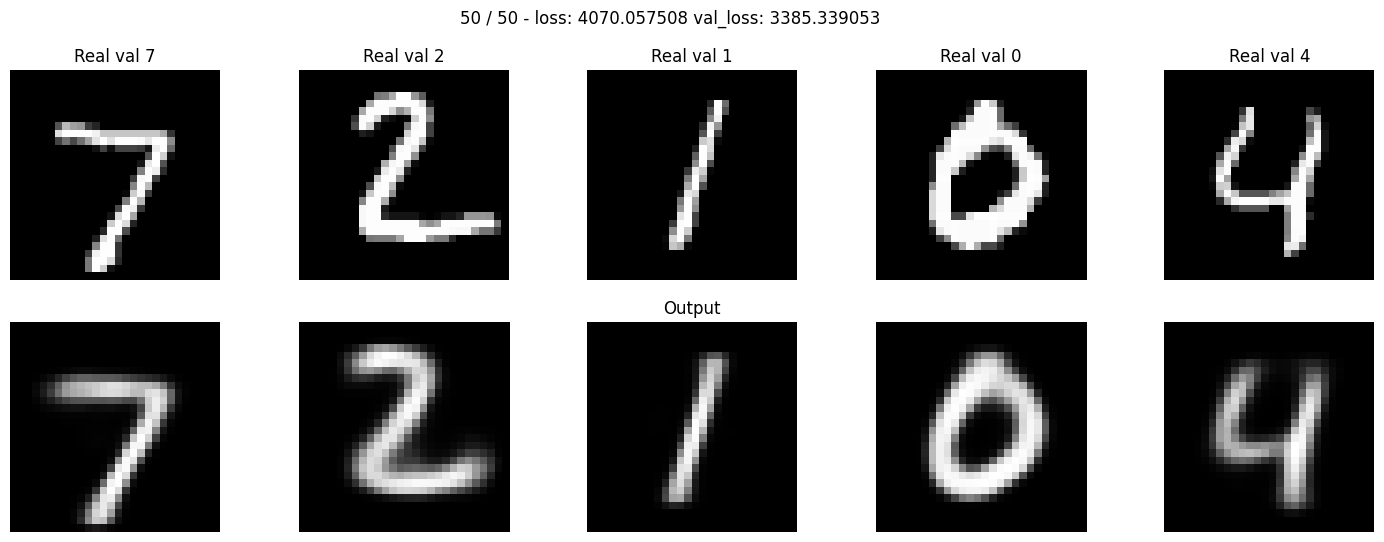

In [ ]:
# criterion = nn.MSELoss()
criterion = VAELoss()
optimizer = torch.optim.Adam(autoencoder_cvae.parameters(), lr=0.0001, weight_decay=1e-5)
EPOCHS = 50
train_cvae(autoencoder_cvae, train_loader, criterion, optimizer, epochs=EPOCHS)

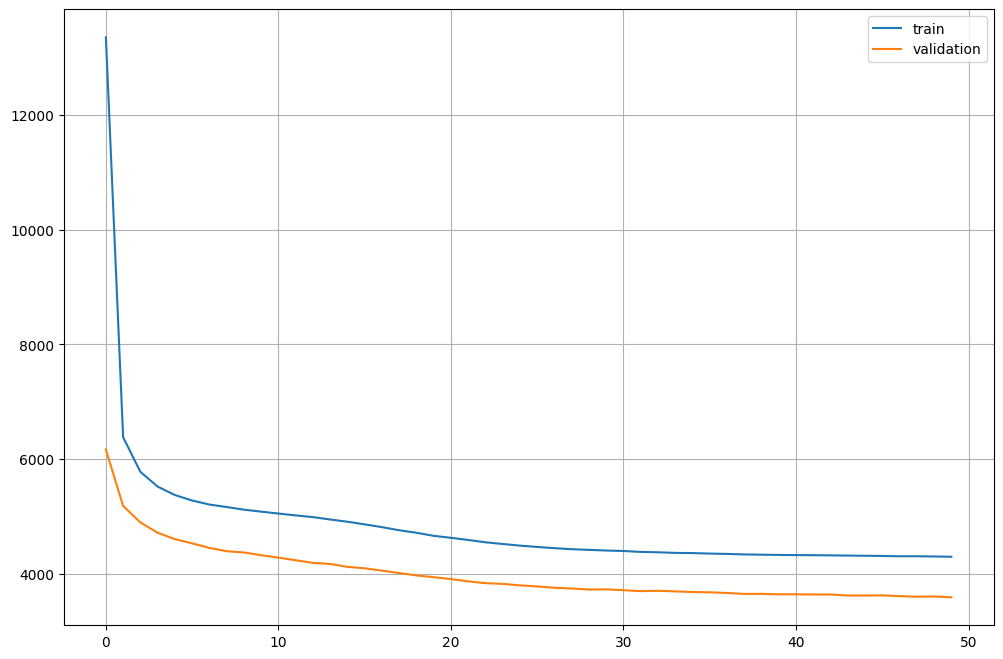

In [ ]:
show_metrics(losses)

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [ ]:
def get_sample_from_cvae(cvae, latent_vector, class_labels):
  cvae.eval()

  with torch.no_grad():
      reconstruction = cvae.decode(latent_vector, class_labels).cpu().detach()
  return reconstruction


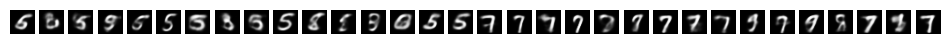

In [ ]:
sampled_latent_vector = torch.randn(MNIST_BATCH_SIZE, HIDDEN_DIM).to(device)
labels = [5] * (MNIST_BATCH_SIZE // 2) + [7] * (MNIST_BATCH_SIZE // 2)
class_labels_to_generate = torch.tensor(labels).to(device)


# Call the function to sample and display images
reconstruction = get_sample_from_cvae(autoencoder_cvae, sampled_latent_vector, class_labels_to_generate)
reconstruction = reconstruction.view(-1, MNIST_IMAGE_SIZE, MNIST_IMAGE_SIZE, CHANNELS)
show_digits(reconstruction, num_images=MNIST_BATCH_SIZE)


Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
def get_latent_vectors_cvae(model, dataloader):
  # Step 1
  model.eval()

  latent_vectors = []
  true_labels = []

  with torch.no_grad():
      for batch in dataloader:
          images, labels = batch
          images = images.to(device)
          labels = labels.to(device)
          mu, _ = model.encode(images, labels)
          latent_vectors.append(mu.cpu())
          true_labels.append(labels.cpu().float())

  # Convert lists of tensors to a single tensor
  latent_vectors = torch.cat(latent_vectors, dim=0)
  true_labels = torch.cat(true_labels, dim=0)

  return latent_vectors, true_labels

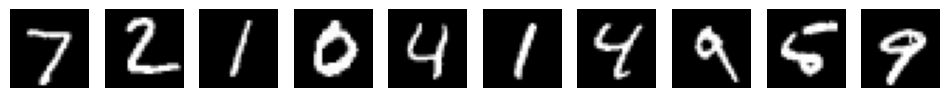

true_labels tensor([7., 2., 1., 0., 4., 1., 4., 9., 5., 9.])


In [ ]:
latent_vectors, true_labels = get_latent_vectors_cvae(autoencoder_cvae, test_loader)
# Get a batch of images from the training loader
images_batch, _ = next(iter(test_loader))
show_digits(images_batch, num_images=10)

# print("latent vectors",latent_vectors[:10])
print("true_labels", true_labels[:10])

<ipython-input-161-8861c6149737>:15: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(latent_vectors[indices, 0], latent_vectors[indices, 1], c=colors[class_idx], label=str(int(class_label)))


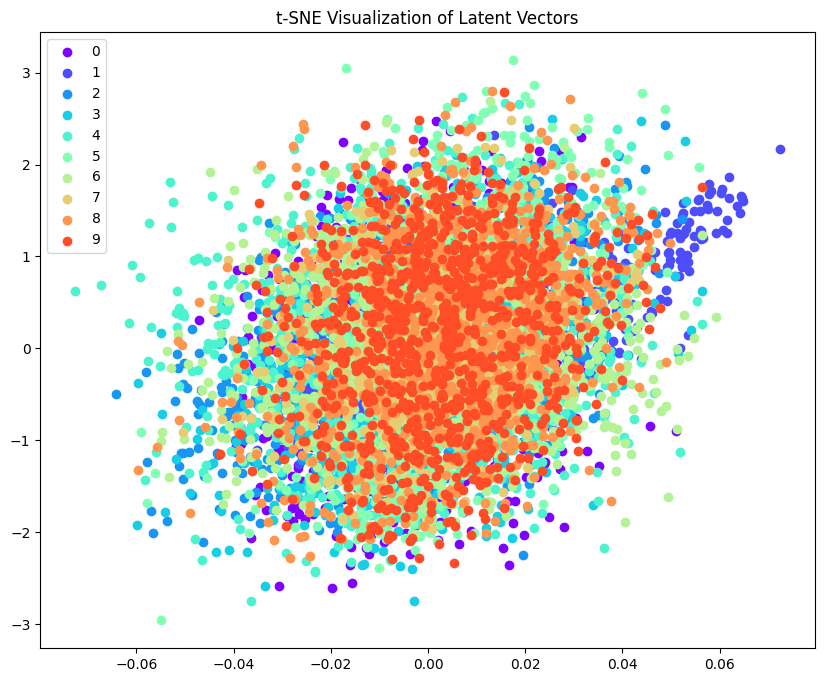

In [ ]:
plot_tsne(latent_vectors[:10000], true_labels[:10000])

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

They look similar.
Have to submit, so no time to implement bonuses right now.

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума.
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом.

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)

In [ ]:
<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>

In [ ]:
<тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>

  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат

    distances,neighbors = get_similar(image,n_neighbors=11)

    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")

    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>